<a href="https://colab.research.google.com/github/PatriciaLucas/CausalForecasting/blob/main/Experimentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Experimentos e Resultados

```
Universidade Federal de Minas Gerais - UFMG
Disciplina: Causalidade em Aprendizado de Máquina (DCC)
Projeto Final: Modelo Causal para Previsão de Séries Temporais Multivariadas
Professor: Anísio Mendes Lacerda
```

###Instalação e importação de pacotes

In [ ]:
!git clone https://github.com/PatriciaLucas/CausalForecasting.git

In [ ]:
!pip install pyFTS

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from CausalForecasting import functions as cf
import seaborn as sns
from pyFTS.common import Util
from pyFTS.benchmarks import Measures
from pyFTS.partitioners import Grid
from pyFTS.models import hofts, pwfts
from pyFTS.common import Membership
from pyFTS.models.multivariate import mvfts, wmvfts, cmvfts, grid
from pyFTS.models.multivariate import common, variable, mvfts
from pyFTS.models.seasonal import partitioner as seasonal
from pyFTS.models.seasonal.common import DateTime
import warnings
warnings.filterwarnings("ignore")

##Experimentos

Os experimentos foram realizados da seguinte forma:

<img src="https://github.com/PatriciaLucas/CausalForecasting/blob/main/Figuras/experimentos.png?raw=true" width="800"/> 

###Base de dados:

O dataset é composto por séries temporais das variáveis que geraram links causais no grafo gerado pelo método PCMCI. São elas: Umidade Relativa (UR), Temperatura máxima (T_MAX), Temperatura mínima (T_MIN), Velocidade do vento (V), Radiação (R) e Evapotranspiração de Referência (ETo).

<Figure size 1080x360 with 0 Axes>

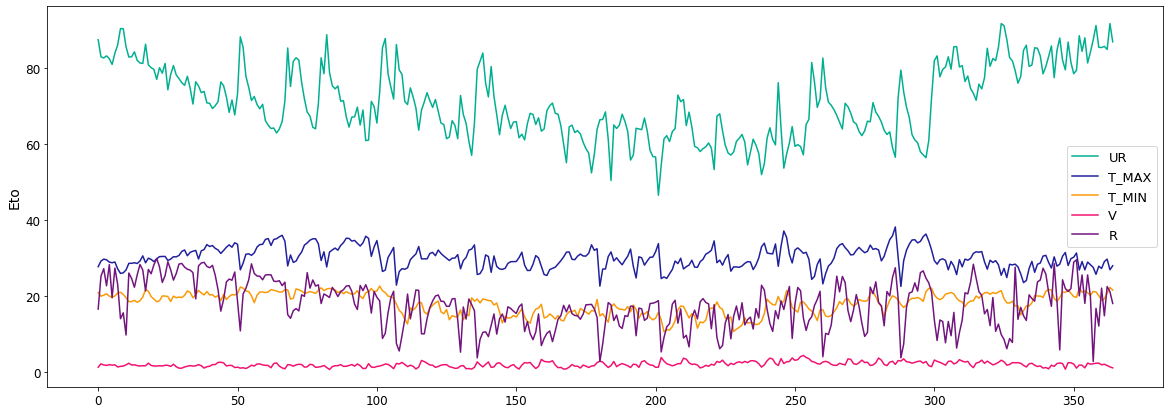

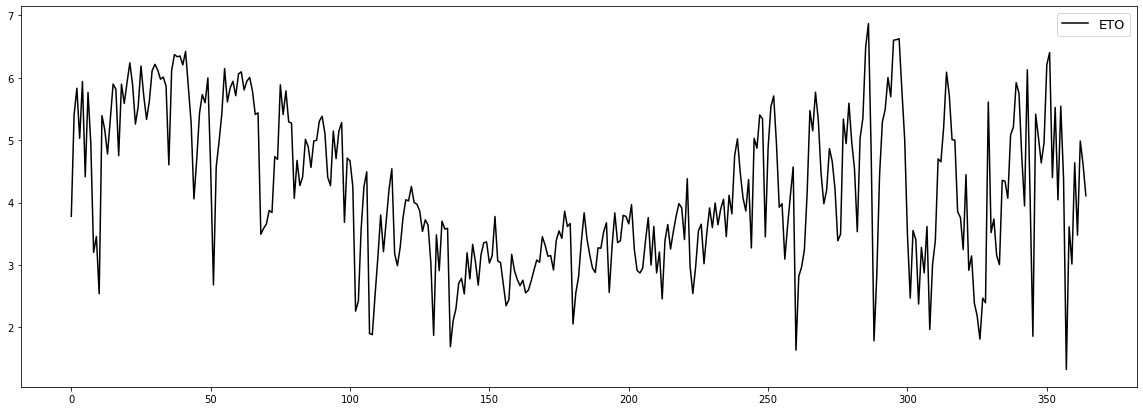

In [6]:
def get_search_dataset(dataset, date_start_train, date_end_train, date_start_test, date_end_test):
  series = pd.read_csv("https://raw.githubusercontent.com/PatriciaLucas/CausalForecasting/main/Datasets/"+dataset+".csv", sep=',')
  mask_train =  (series['DATA'] > date_start_train) & (series['DATA'] <= date_end_train)
  mask_test = (series['DATA'] > date_start_test) & (series['DATA'] <= date_end_test)
  train = series.loc[mask_train].drop(['DATA','P','TM','J'], axis=1)
  test = series.loc[mask_test].drop(['DATA','P','TM','J'], axis=1)
  return train, test
plt.figure(figsize=(15,5))
train, test = get_search_dataset(dataset='riodoce', date_start_train='1990-01-01', date_end_train='1995-12-31', 
                                 date_start_test='1996-01-01', date_end_test='1996-12-31')
from ipywidgets import Label
plt.figure(figsize=(20,7))
palette = sns.color_palette("muted", 4)
sns.lineplot(x=list(range(0, test.shape[0])), y=test['UR'], data=test['UR'], Label='UR', color='#00AF91')
sns.lineplot(x=list(range(0, test.shape[0])), y=test['T_MAX'], data=test['T_MAX'], Label='T_MAX', color='#21209C')
sns.lineplot(x=list(range(0, test.shape[0])), y=test['T_MIN'], data=test['T_MIN'], Label='T_MIN', color='#FA9905')
sns.lineplot(x=list(range(0, test.shape[0])), y=test['V'], data=test['V'], Label='V', color='#F21170')
sns.lineplot(x=list(range(0, test.shape[0])), y=test['R'], data=test['R'], Label='R', color='#72147E')
plt.legend(prop={'size': 13})
plt.tick_params(labelsize=12)
plt.ylabel("Eto", fontsize=14)
pass

plt.figure(figsize=(20,7))
plt.plot(list(range(0, test.shape[0])), test['ETO'], color='black')
plt.legend(['ETO'], prop={'size': 13})
pass

###Execução do experimento 

Métodos testados: ARIMA, Causal Multivariate Times Series (CMTS), Multivariate Fuzzy Times Series (MVFTS) e Weighted Multivariate Fuzzy Times Series (WMVFTS).

Bases de dados: dados climáticos diários do Vale do Jequitinhonha, Vale do Mucuri e Vale do Rio Doce de 1990 a 2020.

Foram realizados 6 experimentos Dados de treino: 5 anos para dados de treino e 1 ano para teste.

In [9]:
datasets = ['jequitinhonha', 'mucuri', 'riodoce']

dates = [['1990-01-01', '1994-12-31', '1995-01-01','1995-12-31'],
         ['1995-01-01', '1999-12-31', '2000-01-01','2000-12-31'],
         ['2000-01-01', '2004-12-31', '2005-01-01','2005-12-31'],
         ['2005-01-01', '2009-12-31', '2010-01-01','2010-12-31'],
         ['2010-01-01', '2014-12-31', '2015-01-01','2015-12-31'],
         ['2015-01-01', '2019-12-31', '2020-01-01','2020-12-31']
        ]

models = ['Arima', 'CMTS', mvfts.MVFTS, wmvfts.WeightedMVFTS]
for s in datasets:
  rmse_Arima, rmse_Causal, rmse_mvfts, rmse_wmvfts = [], [], [], []
  for m in models:
    for d in dates:
      train, test = get_search_dataset(dataset=s, date_start_train=d[0], date_end_train=d[1], 
                                      date_start_test=d[2], date_end_test=d[3])
      if m == 'Arima':
        rmse_A, y_test_A, yhat_A = cf.run_arima(train['ETO'], test['ETO'])
        rmse_Arima.append(rmse_A)
      elif m == 'CMTS':
        rmse_C, y_test_C, yhat_C = cf.run_causalForecasting(train, test)
        rmse_Causal.append(rmse_C)
      elif m == mvfts.MVFTS:
        rmse_M, y_test_M, yhat_M = cf.run_fts(train, test, m)
        rmse_mvfts.append(rmse_M)
      else:
        rmse_W, y_test_W, yhat_W = cf.run_fts(train, test, m)
        rmse_wmvfts.append(rmse_W)
  results = pd.DataFrame(data={"rmse_Arima": rmse_Arima, "rmse_CMTS": rmse_Causal, "rmse_mvfts": rmse_mvfts, "rmse_wmvfts": rmse_wmvfts})
  results.to_csv(s[0]+".csv", sep=',',index=False)

##Resultados

In [21]:
import pandas as pd
j = pd.read_csv('j.csv')
m = pd.read_csv('m.csv')
r = pd.read_csv('r.csv')
hat = pd.read_csv('results.csv')
df = pd.read_csv('df.csv')

In [27]:
print("Média do RMSE:")
models = ["ARIMA", "CMTS", "MVFTS", "WMVFTS"]
tab = pd.DataFrame(data={"Modelos": models, "Jequitinhonha": j.mean(axis=0), "Mucuri": m.mean(axis=0), "Doce": r.mean(axis=0)})
tab.reset_index(drop=True)

Média do RMSE:


,Modelos,Jequitinhonha,Mucuri,Doce
0,ARIMA,1.294740,1.542975,1.360046
1,CMTS,0.684828,0.801762,0.715639
2,MVFTS,0.813333,0.931667,0.878333
3,WMVFTS,0.810000,0.930000,0.881667


In [28]:
print("Desvio padrão do RMSE:")
models = ["ARIMA", "CMTS", "MVFTS", "WMVFTS"]
tab = pd.DataFrame(data={"Modelos": models, "Jequitinhonha": j.std(axis=0), "Mucuri": m.std(axis=0), "Doce": r.std(axis=0)})
tab.reset_index(drop=True)

Desvio padrão do RMSE:


,Modelos,Jequitinhonha,Mucuri,Doce
0,ARIMA,0.141715,0.153764,0.137662
1,CMTS,0.027693,0.046416,0.048606
2,MVFTS,0.030111,0.067355,0.049160
3,WMVFTS,0.032249,0.070993,0.053072


In [17]:
import numpy as np
df = pd.DataFrame({'Datasets':['Jequitinhonha','Jequitinhonha','Jequitinhonha','Jequitinhonha','Jequitinhonha','Jequitinhonha',
                               'Mucuri','Mucuri','Mucuri','Mucuri','Mucuri','Mucuri',
                               'Rio Doce','Rio Doce','Rio Doce','Rio Doce','Rio Doce','Rio Doce'],\
                               'ARIMA':df['ARIMA'],'CMTS':df['CMTS'],'MVFTS':df['MVFTS'],'WMVFTS':df['WMVFTS']})
df = df[['Datasets','ARIMA','CMTS','MVFTS','WMVFTS']]

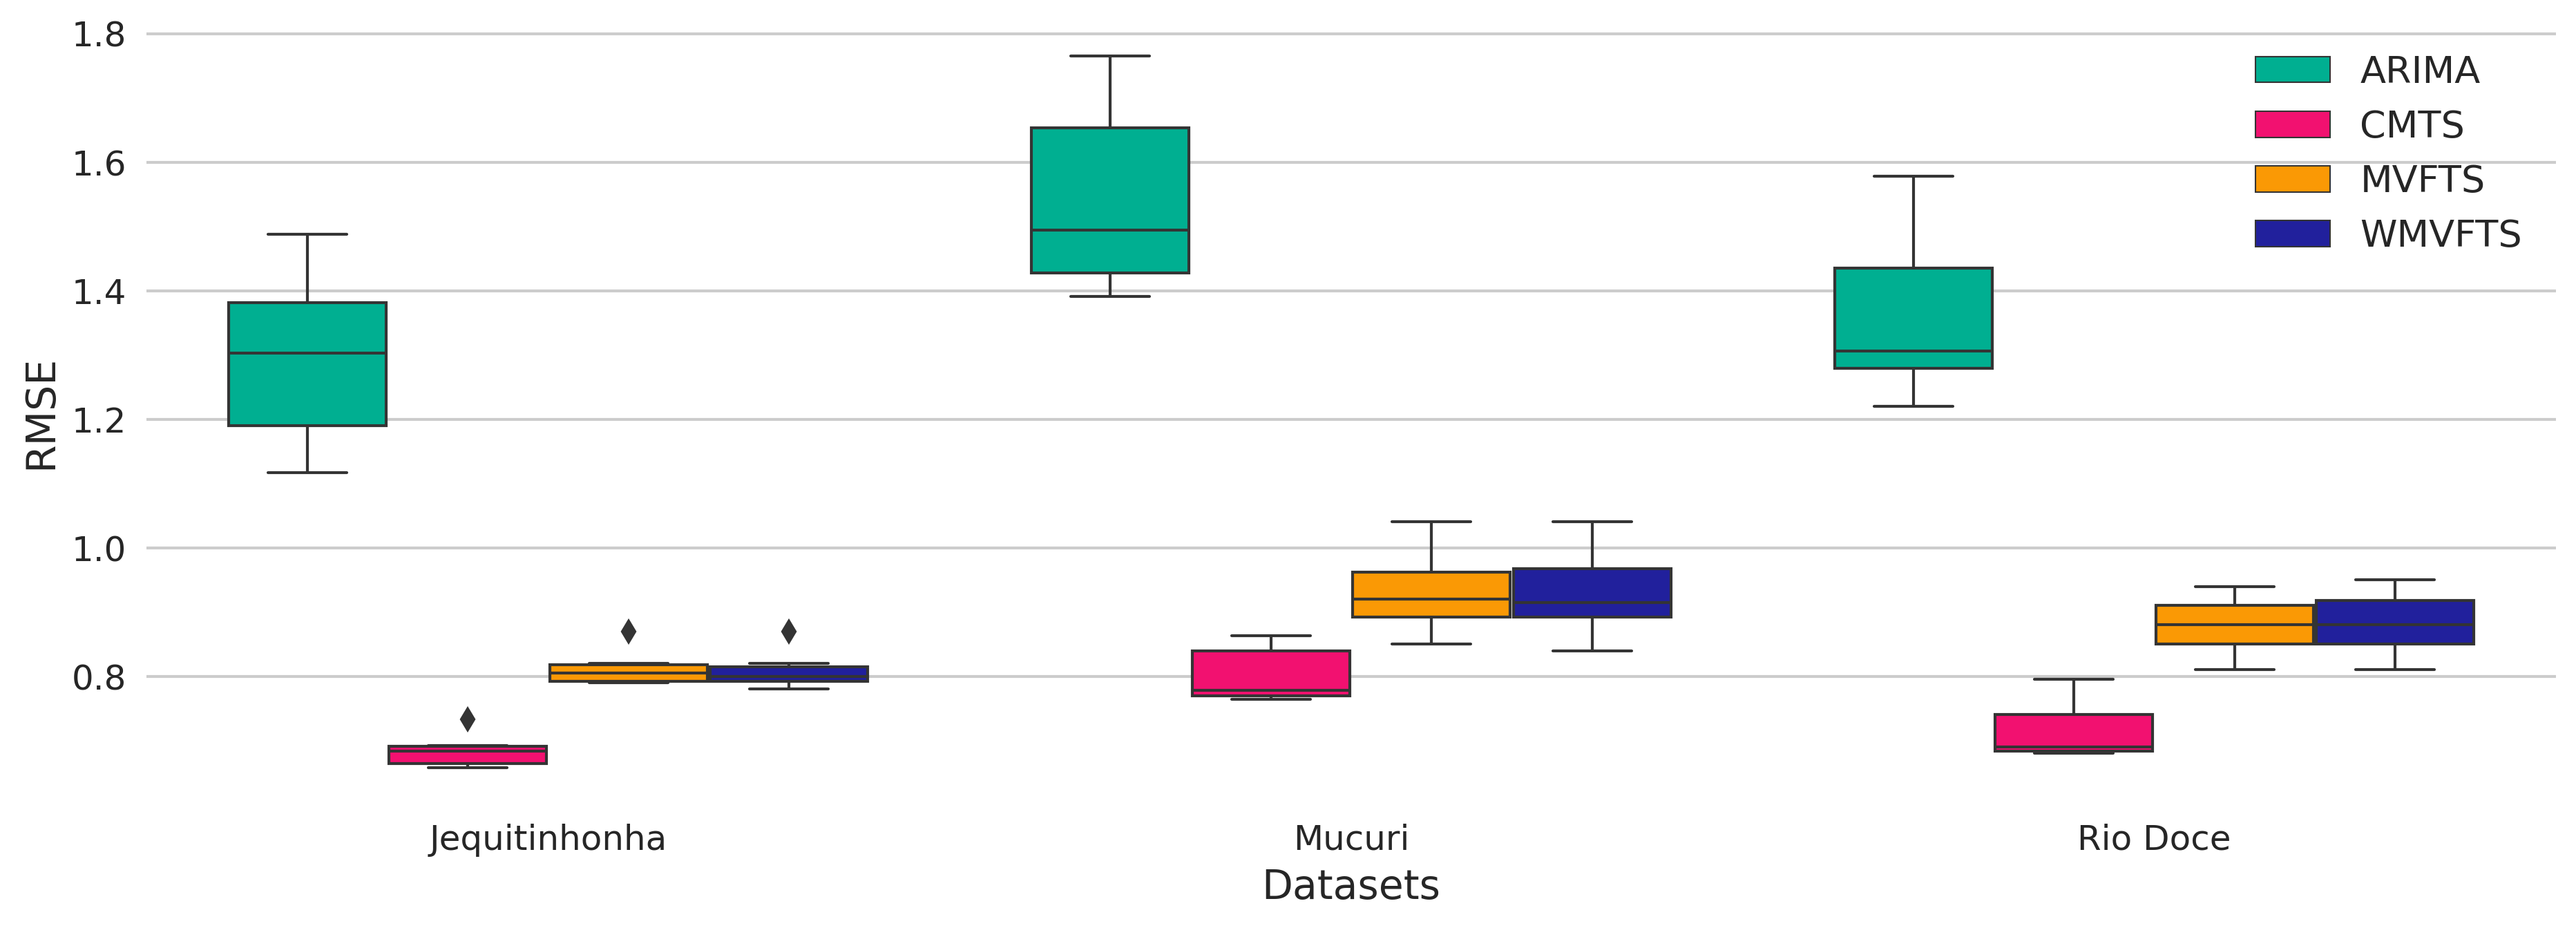

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set_style("whitegrid")
plt.figure(figsize=(15,5), dpi=300)
data = pd.melt(df,id_vars=['Datasets'],value_vars=['ARIMA','CMTS', 'MVFTS', 'WMVFTS'],var_name='Métodos')
ax = sns.boxplot(x='Datasets',y='value',data=data,hue='Métodos', linewidth=1, saturation=1, 
                 palette=sns.color_palette(['#00AF91','#F21170','#FA9905','#21209C'],4))
plt.legend(prop={'size': 13})
plt.tick_params(labelsize=12)
plt.xlabel("Datasets", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
pass

####Vizualização de amostra de previsão de todos os métodos

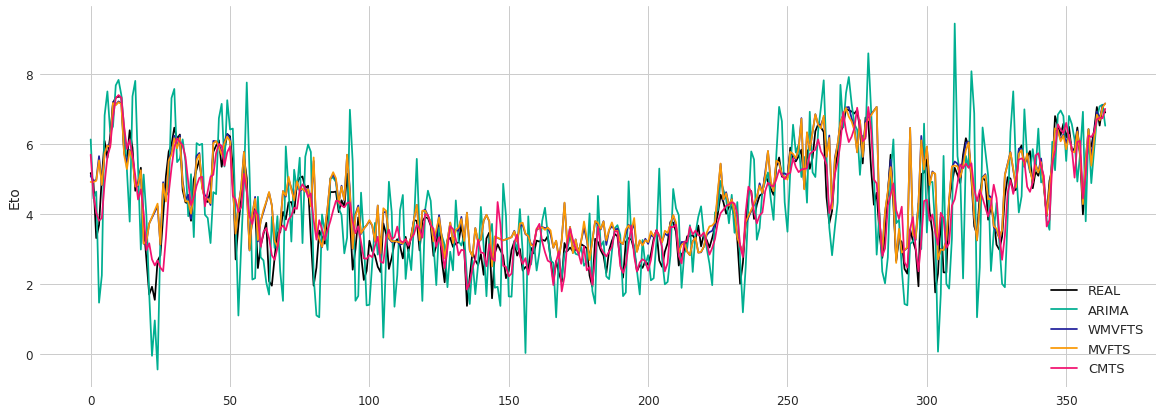

In [ ]:
from ipywidgets import Label
plt.figure(figsize=(20,7))
sns.lineplot(x=list(range(0, 365)), y=hat['REAL'], data=hat['REAL'], color='black', Label='REAL')
palette = sns.color_palette("muted", 4)
sns.lineplot(x=list(range(0, 365)), y=hat['ARIMA'], data=hat['ARIMA'], Label='ARIMA', color='#00AF91')
sns.lineplot(x=list(range(0, 365)), y=hat['WMVFTS'], data=hat['WMVFTS'], Label='WMVFTS', color='#21209C')
sns.lineplot(x=list(range(0, 365)), y=hat['MVFTS'], data=hat['MVFTS'], Label='MVFTS', color='#FA9905')
sns.lineplot(x=list(range(0, 365)), y=hat['CMTS'], data=hat['CMTS'], Label='CMTS', color='#F21170')
plt.legend(prop={'size': 13})
plt.tick_params(labelsize=12)
plt.ylabel("Eto", fontsize=14)
pass

####Resíduos ARIMA

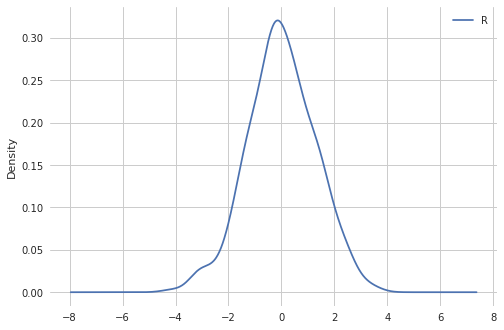

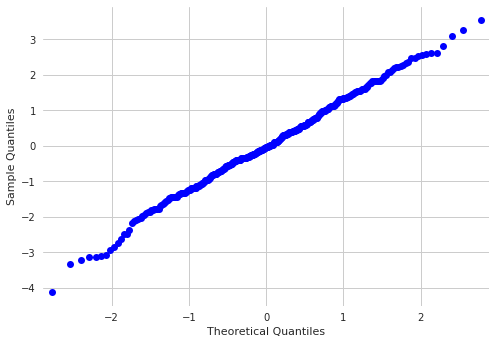

In [ ]:
cf.plot_residuals(hat['ARIMA'], hat['REAL'])

####Resíduos WMVFTS

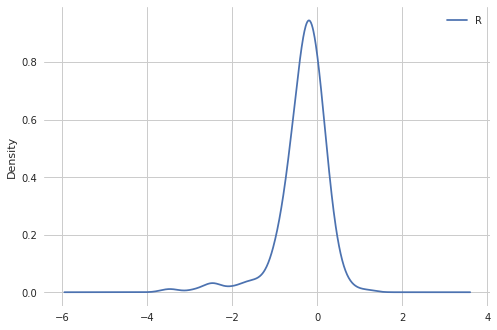

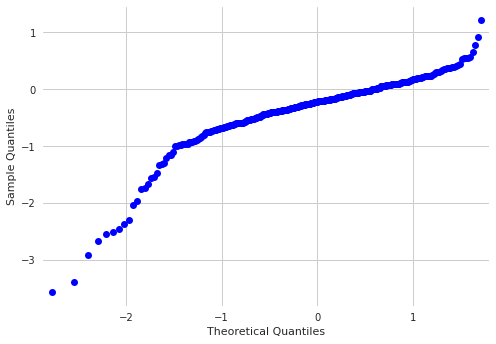

In [ ]:
cf.plot_residuals(hat['WMVFTS'], hat['REAL'])

####Resíduos MVFTS

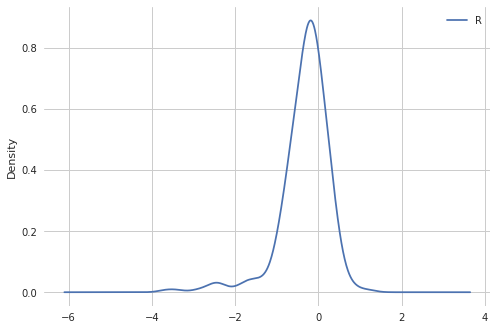

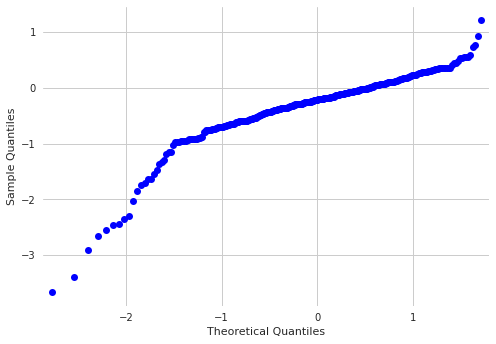

In [ ]:
cf.plot_residuals(hat['MVFTS'], hat['REAL'])

####Resíduos CMTS

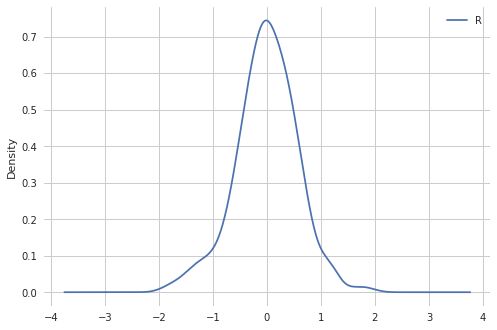

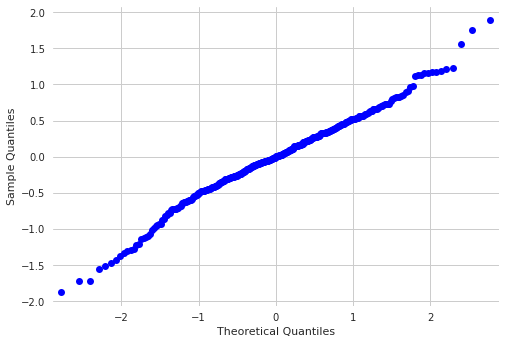

In [22]:
cf.plot_residuals(hat['CMTS'], hat['REAL'])